**Mount Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Prepare Plate Detection Model

**Setup YOLOv7 for ONNX inference**

In [3]:
!pip install 'onnx>=1.9.0' -q
!pip install 'onnx-simplifier>=0.3.6' -q
!pip install onnxruntime -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.4 MB/s eta 0:00:00


In [4]:
# copy model from drive
!cp /content/drive/MyDrive/license_plate_det/yolov7-tiny-platedet80/weights/best.onnx \
    /content

In [5]:
# copy test dataset from drive
!cp -r /content/drive/MyDrive/license_plate_det/plate_coco/images/test \
    /content

In [6]:
# inference for ONNX model
import cv2
cuda = False
w = "/content/best.onnx"
img = cv2.imread('/content/test/Cars102.png')

In [7]:
import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
session = ort.InferenceSession(w, providers=providers)

In [8]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

In [24]:
# plate detector
def plate_detector(img):
    names = ['license']

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    image = img.copy()
    image, ratio, dwdh = letterbox(image, auto=False)
    image = image.transpose((2, 0, 1))
    image = np.expand_dims(image, 0)
    image = np.ascontiguousarray(image)

    im = image.astype(np.float32)
    im /= 255
    im.shape

    outname = [i.name for i in session.get_outputs()]
    outname

    inname = [i.name for i in session.get_inputs()]
    inname

    inp = {inname[0]:im}

    outputs = session.run(outname, inp)[0]
    return outputs, ratio, dwdh

# Prepare Super Resolution Model

**Setup Super Resolution Model**

In [10]:
!git clone https://github.com/braindotai/Real-Time-Super-Resolution.git
%cd Real-Time-Super-Resolution
!pip install -r requirements.txt -q
!ls
%cd ..

Cloning into 'Real-Time-Super-Resolution'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 59 (delta 4), reused 9 (delta 2), pack-reused 46
Receiving objects: 100% (59/59), 43.96 MiB | 33.49 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/Real-Time-Super-Resolution
ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.4.1
callbacks.py  data.py  inference.py  LICENSE	mo

In [11]:
import os
os.rename("/content/Real-Time-Super-Resolution", "/content/RTSR")

In [13]:
import tensorflow as tf
import cv2
import numpy as np
from RTSR.data import visualize_samples
from RTSR.models import Generator

generator = Generator()
generator.load_weights('RTSR/weights/GeneratorVG4(1520).h5')

def enhance_image(image = None, size = (20, 16)):
    cv_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    lr_image = tf.convert_to_tensor(cv_rgb, dtype=tf.float32)

    sr_image = generator(tf.expand_dims(lr_image, 0), training = False)[0]
    sr_image = tf.clip_by_value(sr_image, 0, 255)
    sr_image = tf.round(sr_image)
    sr_image = tf.cast(sr_image, tf.uint8)

    # if visualize:
    #     visualize_samples(images_lists = [[lr_image], [sr_image]], titles = ['LR Image', 'SR_Image'], size = size)

    # if sr_path:
    #     tf.io.write_file(sr_path, tf.image.encode_jpeg(sr_image))

    # Convert TensorFlow tensor to opencv
    np_image = sr_image.numpy()
    np_image = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
    np_image = np_image.astype(np.uint8)

    return np_image


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


# Perform OCR with Pyteserract

**Setup EasyOCR**

In [ ]:
!pip install easyocr -q

In [584]:
def resize_img(image, target=300):
    # Resize the image
    # resized_image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)

    target_width = target
    target_height = target

    # Dapatkan dimensi asli gambar
    original_height, original_width = image.shape[:2]

    # Hitung rasio aspek dari gambar asli
    aspect_ratio = original_width / original_height

    # Tentukan ukuran yang diinginkan sesuai rasio aspek
    if target_width / aspect_ratio <= target_height:
        target_height = int(target_width / aspect_ratio)
    else:
        target_width = int(target_height * aspect_ratio)

    resized_image = cv2.resize(image, (target_width, target_height), interpolation=cv2.INTER_CUBIC)

    return resized_image

In [579]:
import cv2
import numpy as np
from scipy.ndimage import interpolation as inter
from scipy.ndimage import rotate

def correct_skew(image, delta=0.5, limit=5):
    def determine_score(arr, angle):
        data = rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (0,0),  sigmaX=33, sigmaY=33)
    divide = cv2.divide(gray, blur, scale=255)
    thresh = cv2.threshold(divide, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    # se = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
    # bg = cv2.morphologyEx(gray, cv2.MORPH_DILATE, se)
    # out_gray = cv2.divide(gray, bg, scale=255)
    # out_binary = cv2.threshold(out_gray, 25, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    skewness_img = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)
    skewness_thresh = cv2.warpAffine(thresh, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return skewness_img, skewness_thresh

**Number Plate Recognition**

In [580]:
from google.colab.patches import cv2_imshow
import cv2

import easyocr
reader = easyocr.Reader(['en'], gpu=False, quantize=True, verbose=False)

In [680]:
# OCR with easyOCR
def extract_text(img):
    text = reader.readtext(img,
                           workers=2,
                           batch_size=1,
                           allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')

    return text

def plat_recognition(img, box):
    x, y, w, h = box[0], box[1], (box[2] - box[0]), (box[3] - box[1])

    crop_img = img[y:y + h, x:x + w]
    hr_img = enhance_image(crop_img)

    if hr_img.shape[0] > 400 or hr_img.shape[1] > 400:
        hr_img = resize_img(hr_img)
    skewness, thresh_skew = correct_skew(hr_img)
    # gray = cv2.cvtColor(skewness, cv2.COLOR_BGR2GRAY)

    # method 1
    # se = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 8))
    # bg = cv2.morphologyEx(gray_img, cv2.MORPH_DILATE, se)
    # out_gray = cv2.divide(gray_img, bg, scale=255)
    # out_binary = cv2.threshold(out_gray, 25, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    # method 2
    # blur_img = cv2.GaussianBlur(gray_img, (0,0),  sigmaX=33, sigmaY=33)
    # divide = cv2.divide(gray_img, blur_img, scale=255)
    # thresh = cv2.threshold(divide, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    # skewness = correct_skew(thresh)

    inv = 255 - thresh_skew
    kernel = np.ones((2, 2), np.uint8)
    dilate = cv2.dilate(inv, kernel)
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    # morph = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, kernel)

    # custom_config = r'--psm 7 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
    # text = pytesseract.image_to_string(morph, config=custom_config)

    cv2_imshow(hr_img)
    cv2_imshow(thresh_skew)
    cv2_imshow(inv)
    cv2_imshow(dilate)
    # cv2_imshow(tsh_img)

    # try:
    result = ""
    text = extract_text(dilate)
    if text:
        print(text)
        if text[0][2] > 0.3:
            for s in text:
                result += s[1]
            return result

    text = extract_text(skewness)
    if text:
        print(text)
        for s in text:
            result += s[1]
        return result
    # except:
    #     text = "not detected"

    result = "not detected"
    return result


In [696]:
# automatic number plate recognition
def anpr(img):
    # plate detector
    outputs, ratio, dwdh = plate_detector(img)

    ori_images = [img.copy()]
    license_num = ""

    for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
        image = ori_images[int(batch_id)]
        box = np.array([x0,y0,x1,y1])
        box -= np.array(dwdh*2)
        box /= ratio
        box = box.round().astype(np.int32).tolist()

        if score >= 0.55:
            # plate recognition
            license_num = plat_recognition(image, box)

            color = [0, 255, 0]
            if license_num == "not detected":
                color = [0, 0, 255]

            license_num = license_num.strip()

            cv2.rectangle(image, box[:2], box[2:], color, 2)
            cv2.putText(image, license_num, (box[0], box[1] - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, thickness=2)

    # cv2_imshow(ori_images[0])
    ori_images[0] = cv2.cvtColor(ori_images[0], cv2.COLOR_BGR2RGB)
    return ori_images[0]

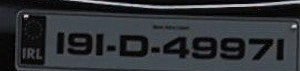

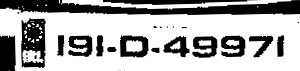

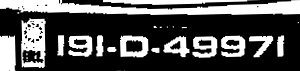

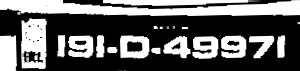

[([[50, 23], [293, 23], [293, 68], [50, 68]], '191LD749971', 0.2781317512599684)]
[([[21, 49], [45, 49], [45, 65], [21, 65]], 'IRL', 0.4001379290155227), ([[51, 29], [291, 29], [291, 65], [51, 65]], 'I91D49971', 0.45605367869215974)]


In [703]:
img_path = "/content/FUNERAL Monaghan  14333947.jpg"
img = cv2.imread(img_path)
license_detected = anpr(img)
# print(license_num)

In [704]:
from PIL import Image
Image.fromarray(license_detected)

Output hidden; open in https://colab.research.google.com to view.

In [702]:
!wget https://static.independent.co.uk/2023/08/03/14/FUNERAL%20Monaghan%20%2014333947.jpg

--2024-05-10 11:46:37--  https://static.independent.co.uk/2023/08/03/14/FUNERAL%20Monaghan%20%2014333947.jpg
Resolving static.independent.co.uk (static.independent.co.uk)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to static.independent.co.uk (static.independent.co.uk)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 650998 (636K) [image/jpeg]
Saving to: ‘FUNERAL Monaghan  14333947.jpg’

FUNERAL Monaghan  1 100%[===================>] 635.74K  --.-KB/s    in 0.009s  

2024-05-10 11:46:37 (72.0 MB/s) - ‘FUNERAL Monaghan  14333947.jpg’ saved [650998/650998]

